<a href="https://colab.research.google.com/github/jrickey24/FlightDelayPrediction/blob/main/FlightDelayPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Package Dependencies

In [43]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load Data

In [ ]:
# Import Raw Text CSV File From GitHub Repo
csv_url = 'https://raw.githubusercontent.com/jrickey24/MLDatasets/main/Airlines_OG.csv'
df = pd.read_csv(csv_url)
pd.set_option("display.max_columns", None)
sns.set_style("dark")
df.drop_duplicates()

# Filter By Top US Airlines & Common US Airports

In [45]:
common_airports = ['ATL','DFW','DEN','ORD','LAX','CLT','LAS','PHX','MCO','SEA','MIA','IAH','JFK','FLL','EWR','SFO']
top_us_airlines = ['AA', 'DL', 'UA', 'WN']
df = df.loc[df['AirportTo'].isin(common_airports) & df['AirportFrom'].isin(common_airports) & df['Airline'].isin(top_us_airlines)]

# Visualize Flights & Delays By Airline

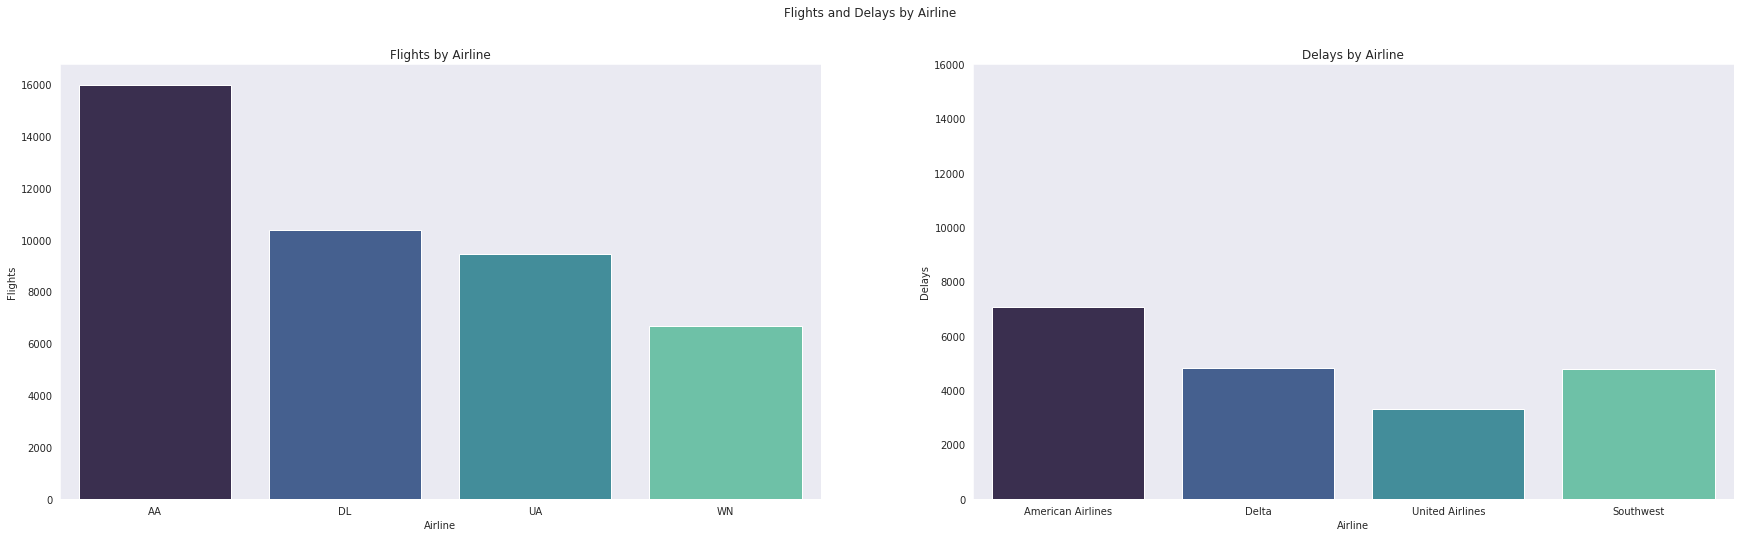

In [46]:
count_by_airline = df.groupby('Airline', as_index=False).Delay.count()
aa_details = df.apply(lambda x : True if x['Airline'] == 'AA' and x['Delay'] == 1 else False, axis = 1) # Get Count Of Delayed AA Flights = American
AA = len(aa_details[aa_details == True].index)
dl_details = df.apply(lambda x : True if x['Airline'] == 'DL' and x['Delay'] == 1 else False, axis = 1) # Get Count Of Delayed DL Flights = Delta  
DL = len(dl_details[dl_details == True].index)
ua_details = df.apply(lambda x : True if x['Airline'] == 'UA' and x['Delay'] == 1 else False, axis = 1) # Get Count Of Delayed UA Flights = United 
UA = len(ua_details[ua_details == True].index)
wn_details = df.apply(lambda x : True if x['Airline'] == 'WN' and x['Delay'] == 1 else False, axis = 1) # Get Count Of Delayed WN Flights = Southwest  
WN = len(wn_details[wn_details == True].index)

delays_by_airline = {"American Airlines": AA, "Delta": DL, "United Airlines": UA, "Southwest": WN}
keys = list(delays_by_airline.keys())
values = list(delays_by_airline.values())

fig, axs = plt.subplots(ncols=2, figsize=(30,8))
fig.suptitle('Flights and Delays by Airline')
sns.barplot(x='Airline', y='Delay', data=count_by_airline, palette="mako", ax=axs[0])
sns.barplot(x=keys, y=values, palette="mako", ax=axs[1])
axs[0].set(title='Flights by Airline', xlabel='Airline', ylabel='Flights')
axs[1].set(title='Delays by Airline', xlabel='Airline', ylabel='Delays')
axs[1].set_ylim(0,16000);

# Format Data For Model Training

In [47]:
df['AirportFrom'] = "from_" + df['AirportFrom'].map(str)
df['AirportTo'] = "to_" + df['AirportTo'].map(str)

# Encode Non-numeric Classifiers for Calculations
airline_dummies = pd.get_dummies(df.Airline)
airport_from_dummies = pd.get_dummies(df.AirportFrom)
airport_to_dummies = pd.get_dummies(df.AirportTo)

# Concat Dummies
model_input_x = pd.concat([df,airline_dummies,airport_from_dummies,airport_to_dummies], axis=1)

# Drop the Unnecessary Columns(id & Flight #s) & Plain Text Version of the Columns for Modeling
model_input_x.drop(['id', 'Flight', 'Airline', 'AirportFrom', 'AirportTo'], axis=1, inplace=True)
target_y = df['Delay'] # Set Delay As Target Value Y
model_input_x.drop(['Delay'], axis=1, inplace=True) # Drop Delay Column From Model Input X
#model_input_x.head(10)

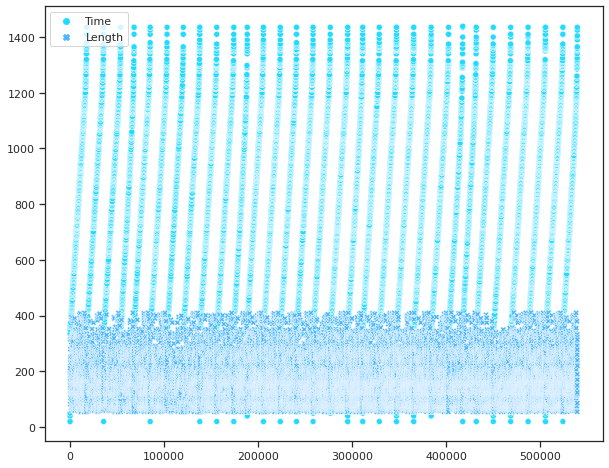

In [142]:
df_delayed = df.loc[(df['Delay'] == 1)]
plt.figure(figsize = (10,8))
data = [df_delayed.Time, df_delayed.Length]
sns.scatterplot(data=data)
sns.set(style="ticks", palette="cool")
plt.show()

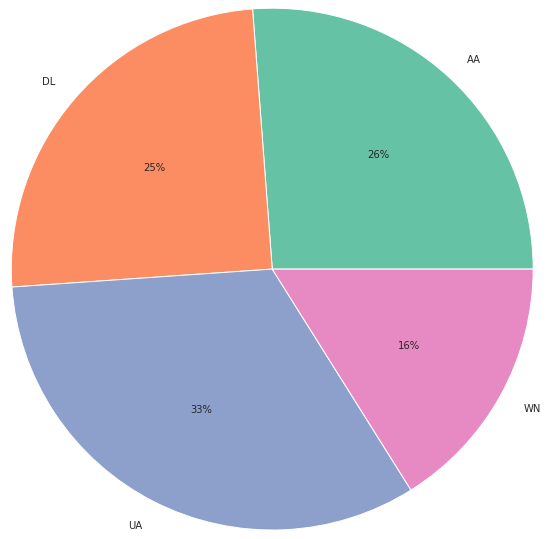

In [49]:
aa_plot = len(model_input_x[model_input_x.AA == 1])/AA
dl_plot = len(model_input_x[model_input_x.DL == 1])/DL
ua_plot = len(model_input_x[model_input_x.UA == 1])/UA
wn_plot = len(model_input_x[model_input_x.WN == 1])/WN
pie_values = [aa_plot, dl_plot, ua_plot, wn_plot]
colors = sns.color_palette('Set2')[0:len(top_us_airlines)]
plt.pie(pie_values, labels=top_us_airlines, colors = colors, autopct='%.0f%%', radius=3)
plt.show()

# Train The Model & Visualize Feature Importance

X_train : (33964, 39)
X_test : (8492, 39)
Train Accuracy -: 0.81


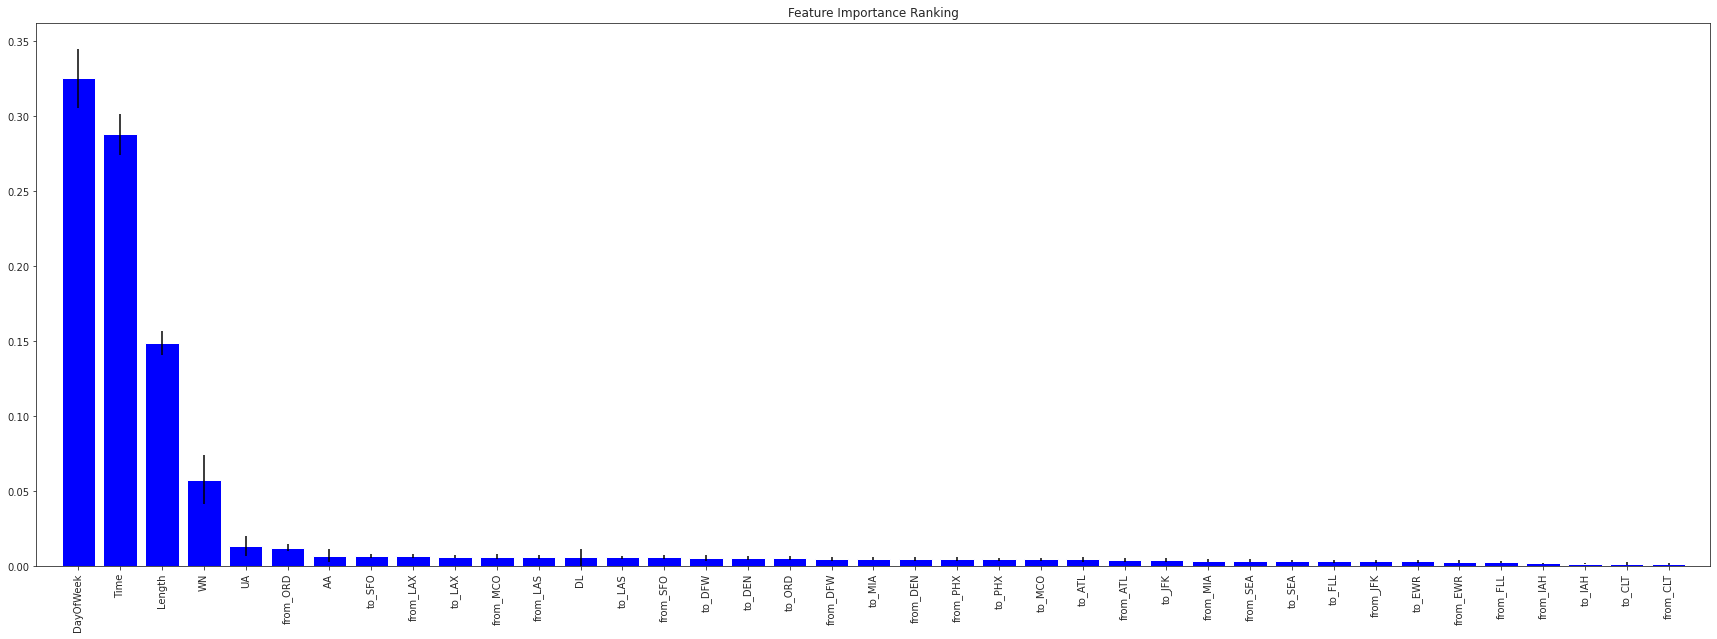

In [58]:
X_train, X_test, y_train, y_test = train_test_split(model_input_x, target_y, train_size=0.80, random_state=42)
print(f'X_train : {X_train.shape}')
print(f'X_test : {X_test.shape}')

random_forest_model = RandomForestClassifier(n_estimators=800, max_features=15, random_state=42)      
random_forest_model = random_forest_model.fit(X_train,y_train)

y_pred = random_forest_model.predict(X_test)
print(f'Train Accuracy -: {random_forest_model.score(X_train, y_train):.2f}')
#print(f'Test Accuracy -: {random_forest_model.score(X_test, y_test):.2f}')

importances = random_forest_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest_model.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
#for feat in range(X_train.shape[1]):print("%d. feature %d (%f)" % (feat + 1, indices[feat], importances[indices[feat]]))
plt.figure(1, figsize=(30, 10))
plt.title("Feature Importance Ranking")
plt.bar(range(X_train.shape[1]), importances[indices], color="b", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]) ,X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Select Flight Options To Determine Delay Risk

In [90]:
airline = "Southwest Airlines" #@param ["Delta Airlines", "American Airlines","Southwest Airlines", "United Airlines"]
airport_from = "ATL" #@param ["ATL","DFW","DEN","ORD","LAX","CLT","LAS","PHX","MCO","SEA","MIA","IAH","JFK","FLL","EWR","SFO"]
airport_to = "JFK" #@param ["ATL","DFW","DEN","ORD","LAX","CLT","LAS","PHX","MCO","SEA","MIA","IAH","JFK","FLL","EWR","SFO"]
day = "Monday" #@param ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

valid_flight = True

# Airport To And From Distance For Missing Values
airport_time_length = {"DEN_CLT":[539,185], "SFO_CLT":[733,286], "SFO_FLL":[1375,308], "LAX_IAH":[617,188], "LAX_SEA":[866,164], "LAX_CLT":[825,266],
"LAS_EWR":[862,284], "LAS_IAH":[620,174], "LAS_CLT":[761,246], "PHX_CLT":[568,227], "PHX_IAH":[804,154], "PHX_EWR":[863,275],
"MCO_EWR":[817,155], "MCO_SEA":[798,385], "MCO_IAH":[793,154], "MCO_CLT":[739,97], "MIA_SEA":[495,400], "MIA_CLT":[792,125],
"JFK_IAH":[1230,257], "JFK_CLT":[806,126], "FLL_CLT":[740,118], "FLL_IAH":[715,170], "FLL_EWR":[787,176], "FLL_SFO":[1022,380],
"SEA_LAX":[730,154], "SEA_CLT":[1014,281], "SEA_MCO":[945,320], "SEA_MIA":[1345,334], "SEA_IAH":[693,245], "SEA_EWR":[816,305],
"EWR_FLL":[787,176], "EWR_IAH":[799,241], "EWR_SEA":[829,371], "EWR_MCO":[744,173], "EWR_PHX":[716,335], "EWR_LAS":[778,346], 
"EWR_CLT":[733,121], "IAH_LAX":[617,188], "IAH_CLT":[767,141], "IAH_LAS":[620,174], "IAH_PHX":[804,154], "IAH_MCO":[793,154],
"IAH_SEA":[693,245], "IAH_JFK":[1230,257], "IAH_FLL":[715,170], "IAH_EWR":[799,241],"CLT_DEN":[539,185], "CLT_LAX":[825,266],
"CLT_LAS":[761,246], "CLT_PHX":[568,227], "CLT_MCO":[739,97], "CLT_SEA":[1014,281], "CLT_MIA":[792,125],"CLT_IAH":[767,141], 
"CLT_JFK":[806,126], "CLT_FLL":[740,118], "CLT_EWR":[733,121], "CLT_SFO":[733,286]}

# Get The Flight Time and Length Values For Model Computation
time_df= model_input_x.loc[(model_input_x["from_" + airport_from] == 1) & (model_input_x["to_" + airport_to] == 1)]
try:
  time_value = math.ceil(time_df["Time"].mean())
  length_value = math.ceil(time_df["Length"].mean())
except: 
    if(airport_from == "MIA" and airport_to == "FLL") or (airport_from == "JFK" and airport_to == "EWR"):
      valid_flight = False
    elif(airport_from == "FLL" and airport_to == "MIA") or (airport_from == "FLL" and airport_to == "SEA"):
      valid_flight = False
    elif(airport_from == "SEA" and airport_to == "FLL") or (airport_from == "EWR" and airport_to == "JFK"):
       valid_flight = False
    elif(airport_from == airport_to):
      valid_flight = False
    else:
      time_value = airport_time_length[airport_from + "_" + airport_to][0]
      lenght_value = airport_time_length[airport_from + "_" + airport_to][1]
if valid_flight == False:
  print("The Airport To and Airport From Combination Selected is Invalid. Please Select a Valid Option & Try Again.")
                  
# Transform DayOfWeek Value To Integer Representation For Model Computation
day_of_week_dict = {"Monday":1,"Tuesday":2,"Wednesday":3,"Thursday":4,"Friday":5,"Saturday":6,"Sunday":7}
day_num = day_of_week_dict[day]

# Transform Airline Value to Expected Input For Model Computation
airline_dict = {"American Airlines": "AA", "Delta Airlines": "DL", "Southwest Airlines": "WN", "United Airlines": "UA"}
airline_code = airline_dict[airline]

# Default Value of All Columns Except DayOfWeek, Time, and Length Are Initialized to Zero
test_df = pd.DataFrame({'DayOfWeek':[day_num], 'Time':[time_value], 'Length':[length_value], 'AA':[0], 'DL':[0], 'UA':[0], 'WN':[0],
       'from_ATL':[0], 'from_CLT':[0], 'from_DEN':[0], 'from_DFW':[0], 'from_EWR':[0], 'from_FLL':[0], 
       'from_IAH':[0], 'from_JFK':[0], 'from_LAS':[0], 'from_LAX':[0], 'from_MCO':[0], 'from_MIA':[0],
       'from_ORD':[0], 'from_PHX':[0], 'from_SEA':[0], 'from_SFO':[0], 'to_ATL':[0], 'to_CLT':[0], 
       'to_DEN':[0], 'to_DFW':[0], 'to_EWR':[0], 'to_FLL':[0], 'to_IAH':[0], 'to_JFK':[0], 'to_LAS':[0],
       'to_LAX':[0], 'to_MCO':[0], 'to_MIA':[0], 'to_ORD':[0], 'to_PHX':[0], 'to_SEA':[0], 'to_SFO':[0]})

# Set Values of Airline, Airport From & Airport To
test_df[airline_code] = 1
test_df["from_" + airport_from] = 1
test_df["to_" + airport_to] = 1
#test_df.head(1)

delay_prediction = random_forest_model.predict(test_df)
result_value = delay_prediction[0]

if valid_flight == True:
  if delay_prediction > 0: print("Flight Delay Risk Is High!")
  else: print("Flight Delay Risk Is Low.") 

Flight Delay Risk Is High!
